In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.neural_network, sklearn.preprocessing, sklearn.metrics, sklearn.utils, sklearn.multiclass

In [2]:
features = pd.read_csv('data/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
tracks = pd.read_csv('data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])

In [16]:
CENS = 'chroma_cens'
CQT = 'chroma_cqt'
STFT = 'chroma_stft'
MFCC = 'mfcc'
RMSE = 'rmse'
BW = 'spectral_bandwidth'
CENT = 'spectral_centroid'
CONT = 'spectral_contrast'
ROLLOFF = 'spectral_rolloff'
TON = 'tonnetz'
ZCR = 'zcr'
all_features = [CENS,CQT,STFT,MFCC,RMSE,BW,CENT,CONT,ROLLOFF,TON,ZCR]

class NN(object):
    def __init__(self,tracks,features):
        self.tracks = tracks
        self.features = features
        self.small = tracks['set', 'subset'] <= 'small'
        self.training = tracks['set', 'split'] == 'training'
        self.validation = tracks['set', 'split'] == 'validation'
        self.testing = tracks['set', 'split'] == 'test'
    
    
    def datasplit(self,feature_array):
        # takes an array of features [MFCC, CONT]
        X_train_temp = self.features.loc[self.small & (self.training | self.validation), feature_array]
        X_test_temp = self.features.loc[self.small & self.testing, feature_array]
        y_train_temp = self.tracks.loc[self.small & (self.training | self.validation), ('track', 'genre_top')]
        y_test_temp = self.tracks.loc[self.small & self.testing, ('track', 'genre_top')]
        y_train = y_train_temp.dropna()
        y_test = y_test_temp.dropna()
        X_train = X_train_temp.drop(y_train_temp.drop(y_train.index).index)
        X_test = X_test_temp.drop(y_test_temp.drop(y_test.index).index)
        EXPERIMENTAL = self.tracks['track', 'genre_top'] == "Experimental"
        X_train = X_train.drop(X_train.loc[EXPERIMENTAL].index)
        y_train = y_train.drop(y_train.loc[EXPERIMENTAL].index)
        X_test = X_test.drop(X_test.loc[EXPERIMENTAL].index)
        y_test = y_test.drop(y_test.loc[EXPERIMENTAL].index)
        return skl.utils.shuffle(X_train, y_train, random_state=42), X_test, y_test
    
    # given parameters achieves the highest score
    def train(self, feature_array=all_features, layer_tuple=(103,15), solver='adam', activation='relu'):
        (X_train, y_train), X_test, y_test = self.datasplit(feature_array)
        scaler = skl.preprocessing.StandardScaler(copy=False)
        scaler.fit_transform(X_train)
        scaler.transform(X_test)
        self.classifier = skl.neural_network.MLPClassifier(early_stopping=True, activation=activation,
                                                           alpha=3e-05, verbose=1,
                                                           hidden_layer_sizes=layer_tuple, nesterovs_momentum= True,
                                                           solver=solver, random_state=1, max_iter=20).fit(X_train,y_train)
        print(self.classifier)
        print("Training Report: ", self.classifier.score(X_train,y_train))
        print(skl.metrics.classification_report(y_train, self.classifier.predict(X_train)))
        print()
        print("Test Report: ", self.classifier.score(X_test,y_test))
        print(skl.metrics.classification_report(y_test, self.classifier.predict(X_test)))
        
    def cross_validation(self,feature_array=all_features):
        (X_train, y_train), X_test, y_test = self.datasplit(feature_array)
        scaler = skl.preprocessing.StandardScaler(copy=False)
        scaler.fit_transform(X_train)
        scaler.transform(X_test)
        
        scores = ['precision', 'recall']

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()
            
            tuned_parameters = {'alpha':10.0 ** -np.arange(1, 7), 'solver':['adam'], 'hidden_layer_sizes':[(250,15),(240,15),(260,15)], 'activation':['logistic']}
            clf = skl.model_selection.GridSearchCV(skl.neural_network.MLPClassifier(), tuned_parameters, cv=3, scoring='%s_macro' % score)
            clf.fit(X_train, y_train)

            print("Best parameters set found on development set:")
            print()
            print(clf.best_params_)
            print()
            print("Grid scores on development set:")
            print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()

            print("Detailed classification report:")
            print()
            print("The model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            print()
            y_true, y_pred = y_test, clf.predict(X_test)
            print(skl.metrics.classification_report(y_true, y_pred))
            print()          
            
    def monitor(self, feature_array=all_features, layer_tuple=(103,15), activation="relu",solver="adam"):
        (X_train, y_train), X_test, y_test = self.datasplit(feature_array)
        scaler = skl.preprocessing.StandardScaler(copy=False)
        scaler.fit_transform(X_train)
        scaler.transform(X_test)

        self.classifier = skl.neural_network.MLPClassifier(hidden_layer_sizes=layer_tuple,
                                                           alpha=3e-05, beta_1=0.99,
                                                           nesterovs_momentum=True,
                                                           learning_rate_init=0.0008996,
                                                           random_state=1, max_iter=1, warm_start=True)
        print(self.classifier)
        train_acc = []
        test_acc = []
        loss = []
        for i in range(15):
            self.classifier.partial_fit(X_train, y_train, np.unique(y_test))
            train_acc.append(self.classifier.score(X_train,y_train))
            test_acc.append(self.classifier.score(X_test,y_test))
            loss.append(self.classifier.loss_)
        print(activation)
        print(solver)
        print("Training Accuracy = ", train_acc[test_acc.index(max(test_acc))])
        print("Test Accuracy = ", max(test_acc))
        print("Loss = ", loss[test_acc.index(max(test_acc))])
        print("Epoch = ", test_acc.index(max(test_acc)))
        plt.plot(train_acc, color="r",label="Training Accuracy")
        plt.plot(test_acc, color="b",label="Test Accuracy")
        plt.legend()
        plt.show()
        
        plt.plot(loss)
        plt.show()
        return test_acc

                

MLPClassifier(activation='relu', alpha=3e-05, batch_size='auto', beta_1=0.99,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(103, 15), learning_rate='constant',
       learning_rate_init=0.0008996, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)
relu
adam
Training Accuracy =  0.7526762327753104
Test Accuracy =  0.6761510605276772
Loss =  0.8010905770938433
Epoch =  5


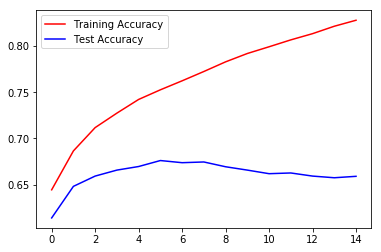

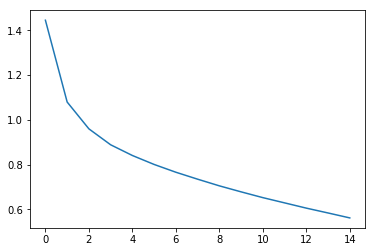

Wall time: 14.5 s


In [17]:
%%time
nn=NN(tracks,features)
nn.monitor()

MLPClassifier(activation='relu', alpha=3e-05, batch_size='auto', beta_1=0.99,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(103, 15), learning_rate='constant',
       learning_rate_init=0.0008996, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)
logistic
adam
Training Accuracy =  0.7526762327753104
Test Accuracy =  0.6761510605276772
Loss =  0.8010905770938433
Epoch =  5


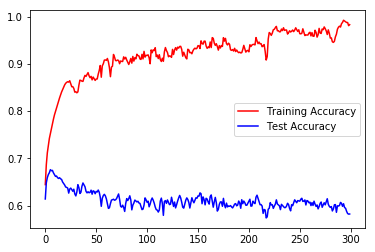

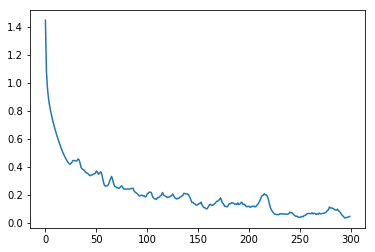

In [12]:
nn = NN(tracks,features)
test_acc_adam = nn.monitor()

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.99, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(250, 15), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)
logistic
adam
Training Accuracy =  0.6996640473750142
Test Accuracy =  0.6564924987066736
Loss =  0.970241645494346
Epoch =  293


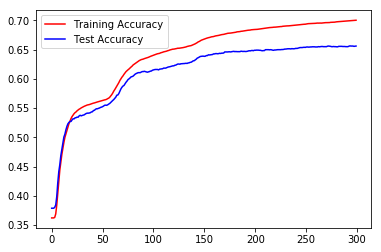

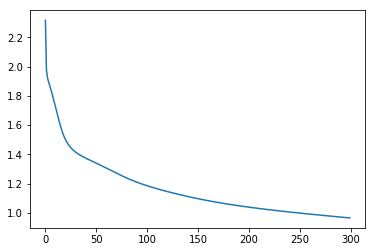

In [15]:
nn = NN(tracks,features)
test_acc_sgd = nn.monitor()

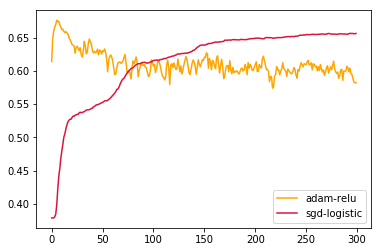

In [18]:
plt.plot(test_acc_adam,c='orange',label='adam-relu')
plt.plot(test_acc_sgd,c='crimson',label='sgd-logistic')
plt.legend()
plt.savefig("adamsgd.png")
plt.show()


logistic
sgd
Training Accuracy =  0.756576699692518
Test Accuracy =  0.6722710812209002
Loss =  0.8035643087678812
Epoch =  290


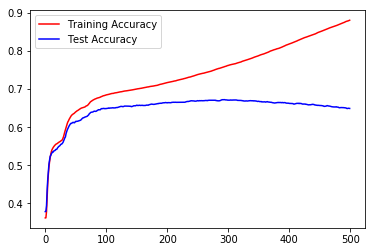

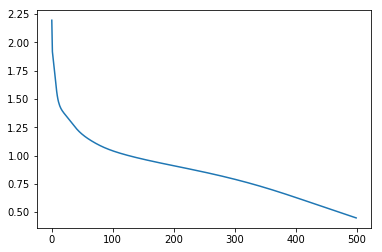

In [162]:
nn = NN(tracks, features)
nn.monitor(all_features,(250,15),solver="sgd",activation="logistic")